In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U albumentations --user

In [3]:
% cd /content/drive/MyDrive/Colab Notebooks/SPACENET7/Multi-temporal.building.tracker/codes

/content/drive/.shortcut-targets-by-id/1a1SCpGq0TH-DdaT37CsAjMBhYiN0BMdO/Colab Notebooks/SPACENET7/Multi-temporal.building.tracker/codes


In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [34]:
!pip install rasterio
!pip install geopandas

# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from torchvision import datasets, transforms, models
from pathlib import Path
import pathlib
import pandas as pd
from data_loader import Dataloader_trdp
from PIL import Image
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
% cd /content/drive/MyDrive/Colab Notebooks/SPACENET7/DATASET/dataset_pruebas

/content/drive/.shortcut-targets-by-id/1a1SCpGq0TH-DdaT37CsAjMBhYiN0BMdO/Colab Notebooks/SPACENET7/DATASET/dataset_pruebas


In [7]:
# Hyperparameters
in_channel = 3
num_classes = 1
learning_rate = 1e-3
batch_size = 64
num_epochs = 1
chip_dimension = 256

In [ ]:
!ls

metrics_prueba_SemanticSegPreTrainedLR0.001  output_csvs  validation
metrics_trdp1.001			     train


In [8]:
train_dir = Path('../../DATASET/dataset_pruebas/train')
test_dir = Path('../../DATASET/dataset_pruebas/validation')
sample_dir = Path('../../DATASET/SN7_buildings_train_sample')

root_dir  = train_dir
csv_file = Path('./output_csvs/df_train_untidy.csv')
csv_file_test = Path('./output_csvs/df_test_untidy.csv')
df = pd.read_csv(csv_file)
df_test = pd.read_csv(csv_file_test)


In [28]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
A.Normalize(mean=mean,std=std)
A.Rotate(limit=(-360, 360), interpolation=4, border_mode=4,p=1),

chip_dimension = 256

transform = A.Compose(
    [
        A.PadIfNeeded(min_height=chip_dimension,min_width=chip_dimension,value=0,p=1),
        A.RandomRotate90(p=1.0),
        ToTensorV2()
    ]
)

In [10]:
train_set   = Dataloader_trdp(root_dir=root_dir,csv_file=csv_file,chip_dimension=chip_dimension,transform=transform)

testing_set = Dataloader_trdp(root_dir=root_dir,csv_file=csv_file_test,chip_dimension=chip_dimension,transform=transform)

In [11]:
print(f"len(train_set): {len(train_set)}")
#print(f"len(testing_set): {len(testing_set)}")

for i in range(len(train_set)):
    sample = train_set[i]
    # verify dimensionality
    print(sample['raster_diff'].shape, sample['mask_diff'].shape)
    if i==1:
        break

len(train_set): 1504
torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


In [12]:
train_set, test_set = torch.utils.data.random_split(train_set, [1000,504])

In [13]:
train_loader = DataLoader(dataset = train_set, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size=batch_size, shuffle = True)

In [14]:
# Display image and label
#train_features,date, train_labels,im_dir,blank = next(iter(train_loader))

# PSNnetLITE

In [15]:
import torchvision.transforms.functional as TF
import random
import numpy as np
print('PyTorch version:', torch.__version__)

PyTorch version: 1.10.0+cu111


In [16]:
class configuration:
    def __init__(self):
        self.experiment_name = "trdp1.001"
        self.pre_load = "True" ## Load dataset in memory
        self.pre_trained = "True"
        self.num_classes = 2
        self.ignore_label = 255
        self.lr = 0.001  # 0.001 if pretrained. 0.1 if scratch
        self.M = [] ##If training from scratch, reduce learning rate at some point
        self.batch_size = 16  # Training batch size
        self.test_batch_size = 4  # Test batch size
        self.epoch = 2 ## Number of epochs
        self.train_root = "./VOC"
        self.download = False
        self.seed = 271828


## Create arguments object
args = configuration()

# Make sure to enable GPU acceleration!
device = 'cuda'

# Set random seed for reproducability
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

In [17]:
class PSPNetLite(nn.Module):
    def __init__(self, args, num_classes, pretrained=True, use_aux=True):
        super(PSPNetLite, self).__init__()
        self.use_aux = use_aux
        
        #### TO FILL: define pytorch default resnet-18 architecture (pretrained and not) 
        if pretrained=="True":
            resnet = models.resnet18(pretrained=True) #
        else:
            resnet = models.resnet18(pretrained=False) #

        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)

        ##Pooling module: simplification of Pyramid Pooling Module of PSPnet
        self.pm = nn.Sequential(
            nn.AdaptiveAvgPool2d(3),
            nn.Conv2d(512, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256, momentum=.95),
            nn.ReLU(inplace=True)
        )

        ## Final classifier to get per-pixel predictions
        self.final = nn.Sequential(
            nn.Conv2d(768, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=.95), #
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )
     
    #### To fill: write the forward pass function:
    #### layer0 --> layer1 --> layer2 --> layer3 --> layer4--> pm --> final
    def forward(self, x):
        x_size = x.size()

        x = self.layer0(x) #layer0
        x = self.layer1(x) #layer1
        x = self.layer2(x) #layer2
        x = self.layer3(x) #layer3
        
        x1 = self.layer4(x)
        x2 = self.pm(x1)

        # Concatenate layer4 features with upsampled Pooling Module features
        x = self.final(torch.cat((x1, F.interpolate(x2, x1.size()[2:], mode='bilinear')), dim=1)) #
        ##return prediction after bilinear upsampling to original size
        return F.interpolate(x, x_size[2:], mode='bilinear')

In [18]:
def _fast_hist(label_pred, label_true, num_classes):
    mask = (label_true >= 0) & (label_true < num_classes)
    hist = np.bincount(
        num_classes * label_true[mask].astype(int) +
        label_pred[mask], minlength=num_classes ** 2).reshape(num_classes, num_classes)
    return hist

def train_SemanticSeg(args, model, device, train_loader, optimizer, epoch):
    # switch to train mode
    model.train()

    train_loss = []
    counter = 1

    criterion = nn.BCEWithLogitsLoss()
    gts_all, predictions_all = [], []

    for batch_idx, (data) in enumerate(train_loader):
        images = data["raster_diff"].float()
        mask = data["mask_diff"].float()#type(torch.LongTensor)
        images, mask = images.to(device), mask.to(device)

        #Forward pass
        outputs = model(images)

        
        #Aggregated per-pixel loss
        loss = criterion(outputs.squeeze(), mask.squeeze(1))
        train_loss.append(loss.item())

        # compute gradient and do SGD step
        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()

        
        if counter % 15 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Learning rate: {:.6f}'.format(
                epoch, int(counter * len(images)), len(train_loader.dataset),
                100. * counter / len(train_loader), loss.item(),
                optimizer.param_groups[0]['lr']))
        counter = counter + 1
    
    return sum(train_loss) / len(train_loss)#, mean_iu

In [19]:
def testing(args, model, device, test_loader):

    # switch to train mode
    model.eval()
    loss_per_batch = []
    test_loss = 0


    ##We ignore index 255, i.e. object contours labeled with 255 in the val GT
    criterion = nn.BCEWithLogitsLoss()
    gts_all, predictions_all = [], []
    with torch.no_grad():
        for batch_idx, (data) in enumerate(test_loader):
            images = data["raster_diff"].float()
            mask = data["mask_diff"].float()#type(torch.LongTensor)
            images, mask = images.to(device), mask.to(device)
            outputs = model(images)

            #Aggregated per-pixel loss
            loss = criterion(outputs.squeeze(), mask.squeeze(1))
            loss_per_batch.append(loss.item())

            preds = outputs.data.max(1)[1].squeeze(1).squeeze(0).cpu().numpy()
            gts_all.append(mask.data.squeeze(0).cpu().numpy())
            predictions_all.append(preds)

    #test_loss /= len(test_loader.dataset)
    loss_per_epoch = [np.average(loss_per_batch)]

    ##Compute Mean Intersection over Union (mIoU)
    ##mIoU: Mean (of all classes) of intersection over union between prediction
    ##and ground-truth
    hist = np.zeros((args.num_classes, args.num_classes))
    for lp, lt in zip(predictions_all, gts_all):
        hist += _fast_hist(lp.flatten(), lt.flatten(), args.num_classes)

    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)

    print('\nTest set ({:.0f}): Average loss: {:.4f}, mIoU: {:.4f}\n'.format(
        len(test_loader.dataset), loss_per_epoch[-1], mean_iu))

    return (loss_per_epoch, mean_iu)

In [ ]:
model = PSPNetLite(1, num_classes=num_classes, pretrained=args.pre_trained).to(device)
print('Total params: %2.fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
model

In [21]:
milestones = args.M
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

In [22]:
CUDA_LAUNCH_BLOCKING = "1"

In [41]:
import os
import time
loss_train_epoch = []
loss_test_epoch = []
acc_train_per_epoch = []
acc_test_per_epoch = []
new_labels = []

cont = 0

res_path = "./metrics_" + args.experiment_name

if not os.path.isdir(res_path):
    os.makedirs(res_path)

for epoch in range(1, args.epoch + 1):
    st = time.time()
    scheduler.step()
    # train for one epoch
    print("PSPnetLite training, epoch " + str(epoch))

    loss_per_epoch = train_SemanticSeg(args, model, device, train_loader, optimizer, epoch)

    loss_train_epoch += [loss_per_epoch]
    
    # test
    loss_per_epoch_test, acc_val_per_epoch_i = testing(args, model, device, test_loader)

    loss_test_epoch += loss_per_epoch_test
    acc_test_per_epoch += [acc_val_per_epoch_i]


    if epoch == 1:
        best_acc_val = acc_val_per_epoch_i

    else:
        if acc_val_per_epoch_i > best_acc_val:
            best_acc_val = acc_val_per_epoch_i

    if epoch == args.epoch:
        torch.save(model.state_dict(), "mySemanticSegModelPreTrained.pth")
        #torch.save(model.state_dict(), "mySemanticSegModelScratch.pth")

    np.save(res_path + '/' + 'LOSS_epoch_train.npy', np.asarray(loss_train_epoch))
    np.save(res_path + '/' + 'LOSS_epoch_val.npy', np.asarray(loss_test_epoch))

    # save accuracies:
    np.save(res_path + '/' + 'accuracy_per_epoch_val.npy', np.asarray(acc_test_per_epoch))

    cont += 1

PSPnetLite training, epoch 1
Train Epoch: 1 [960/1000 (94%)]	Loss: -342227.843750, Learning rate: 0.001000

Test set (504): Average loss: -1427.6698, mIoU: 1.0000



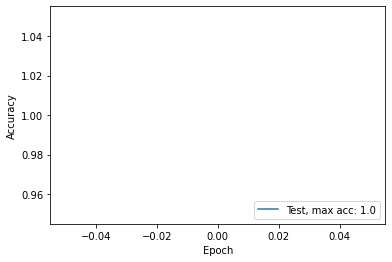

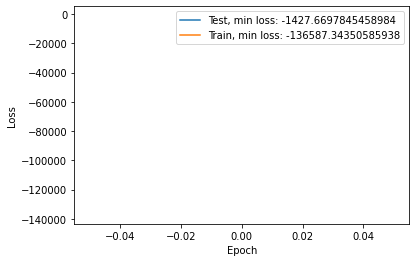

In [42]:
import matplotlib.pyplot as plt
##Accuracy
acc_test = np.load(res_path + '/' + 'accuracy_per_epoch_val.npy')

#Loss per epoch
loss_train = np.load(res_path + '/' + 'LOSS_epoch_train.npy')
loss_test = np.load(res_path + '/' + 'LOSS_epoch_val.npy')

numEpochs = len(acc_test)
epochs = range(numEpochs)

plt.figure(1)
plt.plot(epochs, acc_test, label='Test, max acc: ' + str(np.max(acc_test)))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(epochs, loss_test, label='Test, min loss: ' + str(np.min(loss_test)))
plt.plot(epochs, loss_train, label='Train, min loss: ' + str(np.min(loss_train)))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [39]:
class DeNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


def visualizeSegmentation(args, model, device, test_loader, imageDenormalize, voc_palette):

    # switch to train mode
    model.eval()

    with torch.no_grad():
        for batch_idx, (data) in enumerate(test_loader):

            images = data["raster_diff"].float()
            mask = data["mask_diff"].float()

            images, mask = images.to(device), mask.to(device)

            outputs = model(images)

            plt.figure(batch_idx)

            for i in range(0, images.size(0)):


                image_np = (255*(imageDenormalize(images[i,...]).data.permute(1,2,0).cpu().numpy())).astype(np.uint8)
                gt_np = mask[i,...].squeeze().data.cpu().numpy()
                pred_np = outputs[i,...].data.max(0)[1].squeeze_(0).byte().cpu().numpy()

                img_pil = Image.fromarray(image_np)

                gt_np_color = np.stack((gt_np.copy(), gt_np.copy(), gt_np.copy()), axis=2)
                pred_np_color = np.stack((pred_np.copy(), pred_np.copy(), pred_np.copy()), axis=2)


                for j in range(0, 1):
                    idx_tuple = np.where(gt_np == j)
                    gt_np_color[idx_tuple[0], idx_tuple[1], 0] = colors[j][0]
                    gt_np_color[idx_tuple[0], idx_tuple[1], 1] = colors[j][1]
                    gt_np_color[idx_tuple[0], idx_tuple[1], 2] = colors[j][2]

                    idx_tuple2 = np.where(pred_np == j)
                    pred_np_color[idx_tuple2[0], idx_tuple2[1], 0] = colors[j][0]
                    pred_np_color[idx_tuple2[0], idx_tuple2[1], 1] = colors[j][1]
                    pred_np_color[idx_tuple2[0], idx_tuple2[1], 2] = colors[j][2]


                plt.subplot(args.test_batch_size, 3, i * 3 + 1)
                plt.imshow(img_pil)
                plt.subplot(args.test_batch_size, 3, i * 3 + 2)
                plt.imshow(gt_np_color)
                plt.subplot(args.test_batch_size, 3, i * 3 + 3)
                plt.imshow(pred_np_color)

                
            if batch_idx>7:
                plt.show()
                break


Total params: 15M


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: ignored

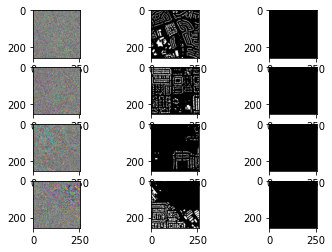

In [40]:

imageDenormalize = DeNormalize(mean,std)

## Color palette for visualization of the 21 classes
colors = np.array([[0, 0, 0], [128, 0, 0]])

model.load_state_dict(torch.load("mySemanticSegModelPreTrained.pth"))
#model.load_state_dict(torch.load("mySemanticSegModelScratch.pth"))

print('Total params: %2.fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))

cont = 0

visualizeSegmentation(args, model, device, test_loader, imageDenormalize, colors)

# Model 1

In [ ]:
# Simple Identity class that let's input pass without changes
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
class PSPNetLite(nn.Module):
    def __init__(self, args, num_classes, pretrained=True, use_aux=True):
        super(PSPNetLite, self).__init__()
        self.use_aux = use_aux
        
        #### TO FILL: define pytorch default resnet-18 architecture (pretrained and not) 
        if pretrained=="True":
            resnet = models.resnet18(pretrained=True) #
        else:
            resnet = models.resnet18(pretrained=False) #

        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)

        ##Pooling module: simplification of Pyramid Pooling Module of PSPnet
        self.pm = nn.Sequential(
            nn.AdaptiveAvgPool2d(3),
            nn.Conv2d(512, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256, momentum=.95),
            nn.ReLU(inplace=True)
        )

        ## Final classifier to get per-pixel predictions
        self.final = nn.Sequential(
            nn.Conv2d(768, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=.95), #
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )
     
    #### To fill: write the forward pass function:
    #### layer0 --> layer1 --> layer2 --> layer3 --> layer4--> pm --> final
    def forward(self, x):
        x_size = x.size()

        x = self.layer0(x) #layer0
        x = self.layer1(x) #layer1
        x = self.layer2(x) #layer2
        x = self.layer3(x) #layer3
        
        x1 = self.layer4(x)
        x2 = self.pm(x1)

        # Concatenate layer4 features with upsampled Pooling Module features
        x = self.final(torch.cat((x1, F.interpolate(x2, x1.size()[2:], mode='bilinear')), dim=1)) #
        ##return prediction after bilinear upsampling to original size
        return F.interpolate(x, x_size[2:], mode='bilinear')

In [ ]:
model = PSPNetLite(1, num_classes=1, pretrained=True).to(device)
model

PSPNetLite(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rel

In [ ]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()#CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
CUDA_LAUNCH_BLOCKING = "1"

In [ ]:
num_epochs  = 1

In [ ]:
from torch.autograd import Variable
# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (load) in enumerate(train_loader):
        if batch_idx == 2:
          break
        print(f"batch_idx: {batch_idx}")
        data = load["raster_diff"].float()
        
        targets = Variable(load["mask_diff"]).float()#type(torch.LongTensor))
        
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        targets = targets.squeeze()
        # forward
        scores = model(data)
        scores = scores.squeeze()
        loss = criterion(scores, targets)
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")


In [ ]:

# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
      for batch_idx, (load) in enumerate(train_loader):
            if batch_idx == 2:
              break
            print(f"batch_idx: {batch_idx}")
            data = load["raster_diff"].float()
            x = data
            targets = Variable(load["mask_diff"]).float()#type(torch.LongTensor))
            y = targets
            y = y.squeeze()
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

      print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")

    model.train()


print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)

Checking accuracy on Training Set
batch_idx: 0
batch_idx: 1
Got 7566148 / 128 with accuracy 5911053.12
Checking accuracy on Test Set


KeyboardInterrupt: ignored

# Backup transfer learnin model

In [43]:
# Model
model = torchvision.models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.avgpool = Identity()
model.classifier = nn.Sequential(
    nn.Conv2d(512, 2, kernel_size=1),
)
model.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

NameError: ignored